# star graph experiment



In [6]:
import warnings
warnings.simplefilter('ignore')
import pickle

In [7]:

from sklearn.metrics import mean_squared_error


def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'sq_norm2':
        penalty_func = SquaredNorm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        prev_w = np.copy(new_w)

        # algorithm 1, line 2
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6

                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], hat_w[i], datapoints[i]['degree'])

            else:
                new_w[i] = hat_w[i]

        # algorithm 1, line 9
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # algorithm 1, line 10
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


### Primal Update 

In [8]:

import torch
import abc
import numpy as np
import abc
from abc import ABC


# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(40):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


### Dual Update 

In [9]:

# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u 
    

# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Create Star Graph

Each node $i \in V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)}, ... , x^{(i,m)} \in R^n$. The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ∼ N(0,I). The labels $y_1^{(i)}, . . . , y_m^{(i)} \in R$ of the nodes $i \in V$ are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. To learn the weight $w^{(i)}$. edge weights are uniform.

In [30]:
import networkx as nx
g = nx.star_graph(n=50)

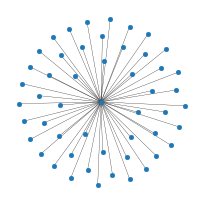

In [39]:
plt.figure(figsize=(10, 10), dpi=20)
nx.draw(g)

In [10]:

from torch.autograd import Variable


def get_star_data(num_nodes, W=None, m=5, n=2, noise_sd=0, is_torch_model=True):
    '''
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = num_nodes
    E = N-1
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    
    cnt=0
    for i in range(E):
        B[cnt, 0] = 1
        B[cnt, i+1] = -1
        cnt+=1

        
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    cnt = 0
   
    for i in range(num_nodes):
        W = W
        features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
        '''
        features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
        '''
        label = np.dot(features, W) + np.random.normal(0,noise_sd)
        '''
        label: the label of the node i that is generated according to the linear model y = x^T w + e
        '''

        true_labels.append(label)


        model = TorchLinearModel(n)
        optimizer = TorchLinearOptimizer(model)
        features = Variable(torch.from_numpy(features)).to(torch.float32)
        label = Variable(torch.from_numpy(label)).to(torch.float32) 

        datapoints[cnt] = {
            'features': features,
            'degree': node_degrees[cnt],
            'w': W,
            'label': label,
            'optimizer': optimizer
        }
        cnt += 1

    return np.array(true_labels), datapoints




In [11]:
from torch.autograd import Variable

def get_star_graph(num_nodes, eps):
    '''
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = num_nodes
    E = N-1
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i in range(E):
        B[cnt, 0] = 1
        B[cnt, i+1] = -1

        weight_vec[cnt] = eps
#         if i == cluster_sizes[0] - 1:
#             weight_vec[cnt] = eps
        cnt += 1
    
    weight_vec = weight_vec[:cnt]
    B = B[:cnt, :]
   

    return B, weight_vec



### Metrics

In [17]:
def get_algorithm1_w_MSE(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]

    true_w = []
    for i in range(len(datapoints)):
        true_w.append(datapoints[i]['w'])

    true_w = np.array(true_w)

    alg1_MSE = mean_squared_error(true_w[samplingset], predicted_w[samplingset])

    return alg1_MSE


In [12]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [21]:
## Sanity check
K = 2
sampling_ratio = 0.2
W = np.array([2+np.random.normal(loc=0.0, scale=0.5), -2+np.random.normal(loc=0.0, scale=0.5)])
true_labels, datapoints = get_star_data(num_nodes=50,W=W, m=10,noise_sd=0.01)
B, weight_vec = get_star_graph(num_nodes=50,eps=0.1) # edge weights are uniform
E, N = B.shape
samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))

_, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, 
                             lambda_lasso=1, penalty_func_name='norm1')

alg1_score = get_algorithm1_w_MSE(datapoints, predicted_w, samplingset)

print('MSE:')
print(alg1_score)

MSE:
0.25292238417330215


In [47]:
PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']
LAMBDA_LASSO = {'norm1':1, 'norm2':1, 'mocha':1, 'sq_norm2':1}
W = np.array([2+np.random.normal(loc=0.0, scale=0.5), -2+np.random.normal(loc=0.0, scale=0.5)])
K = 2000
sampling_ratio = 1
epses = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,5] 
# epses = [1]
colors = ['steelblue', 'darkorange', 'green', 'brown']

# sampling_mses = defaultdict(list)
results_7 = []
true_labels, datapoints = get_star_data(num_nodes=50,W=W,m=10,noise_sd=0.01,is_torch_model=False)


for penalty_func in PENALTY_FUNCS:
    print(penalty_func)
    num_tries = 1    
    lambda_lasso = LAMBDA_LASSO[penalty_func]

    from joblib import Parallel, delayed
    import multiprocessing
    def fun(penalty_func,eps):
        B, weight_vec = get_star_graph(num_nodes=50,eps=eps)
        
        true_w = []
        for i in range(len(datapoints)):
            true_w.append(datapoints[i]['w'])
        true_w = np.array(true_w)
        
        E, N = B.shape

        samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))
        

        _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, 
                                     lambda_lasso, penalty_func)

        alg1_score = get_algorithm1_w_MSE(datapoints, predicted_w, samplingset)
        return alg1_score, predicted_w,true_w
    
    num_cores = multiprocessing.cpu_count()
    results_7.append(Parallel(n_jobs=num_cores)(delayed(fun)(penalty_func,eps)
                                             for eps in epses
                                             for i in range(num_tries))
                  )


norm1
norm2
mocha


In [ ]:
# with open('results_7.pkl', 'wb') as f:
#     pickle.dump(results_7, f)

with open('results_7.pkl', 'rb') as f:
    results_7 = pickle.load(f)

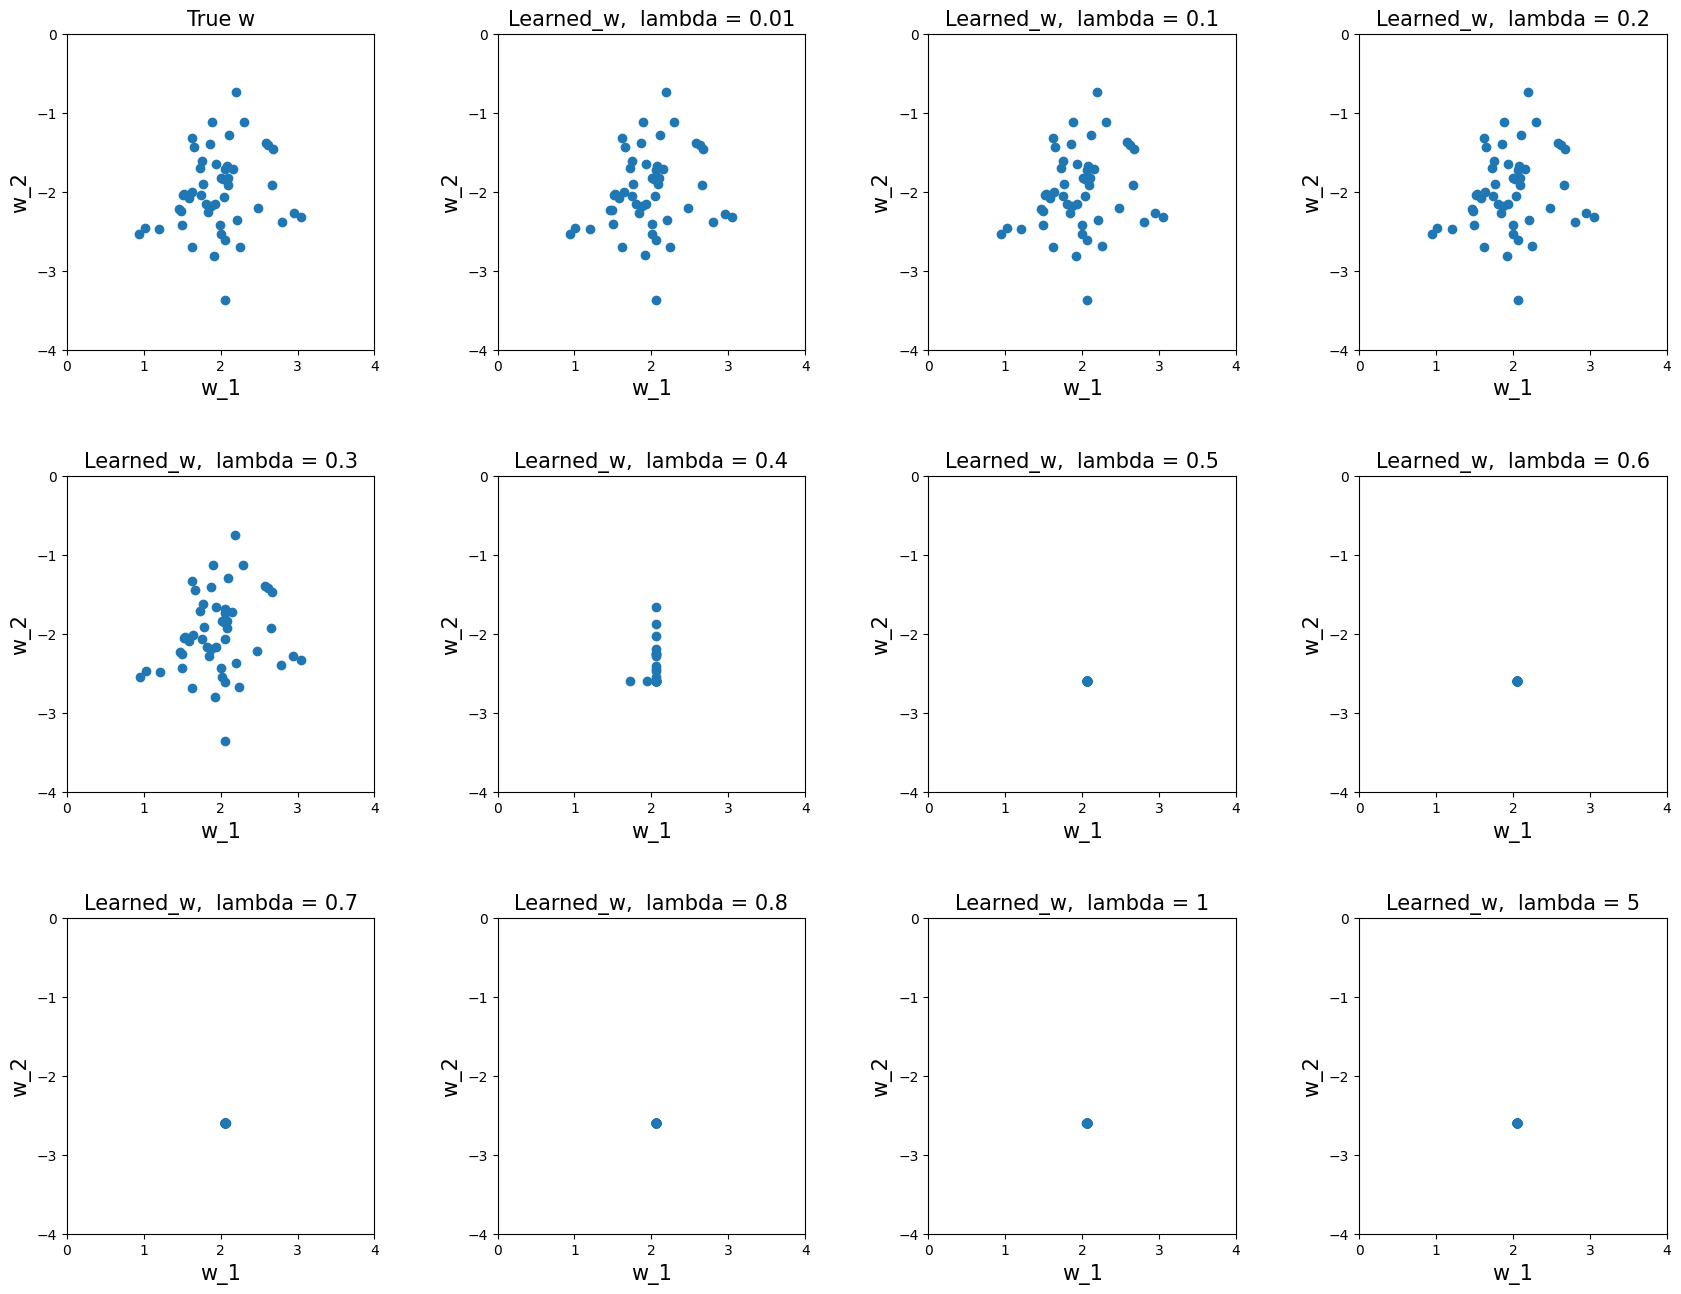

In [48]:
## 1Norm
## As lambda exceed a certain value, local model weights get identical 


epses = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,5] 
fig, axs = plt.subplots(3,4,figsize=(20,15))
cnt = 0
for i in range(3):
    for j in range(4):
        if cnt == 0:
            axs[i][j].scatter(results_7[0][0][2][:,0],results_7[0][0][2][:,1])

            axs[i][j].set_title('True w',fontsize=15)
        else:
            axs[i][j].scatter(results_7[0][cnt-1][1][:,0],results_7[0][cnt-1][1][:,1])
            axs[i][j].set_title('Learned_w,  lambda = {}'.format(epses[cnt-1]),fontsize=15)
        axs[i][j].set_yticks(np.arange(-4, 1, 1.0))
        axs[i][j].set_xticks(np.arange(0,5, 1.0))
        axs[i][j].set_xlabel('w_1',fontsize=15)
        axs[i][j].set_ylabel('w_2',fontsize=15)
        cnt+=1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
        

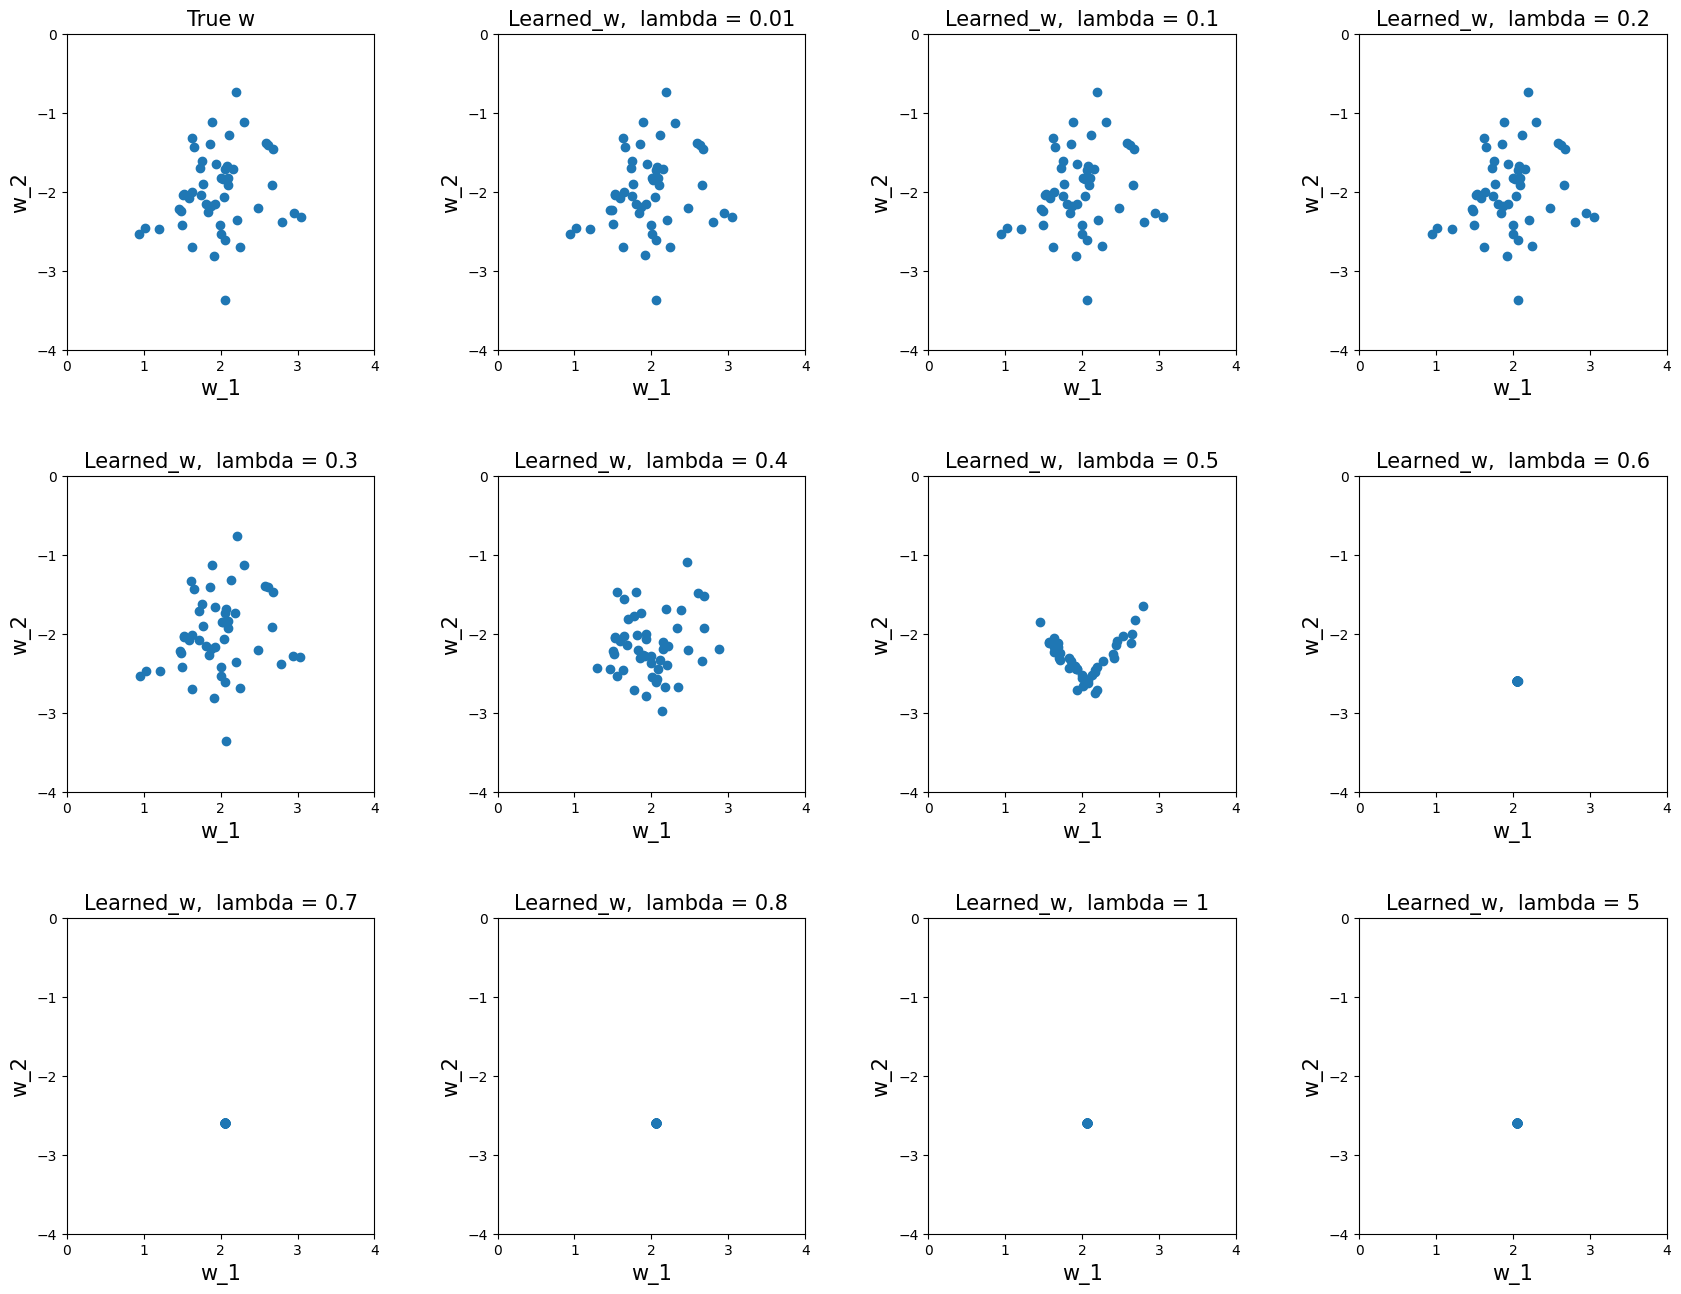

In [51]:
## 2Norm:  the result is similar as 1norm
## As lambda exceed a certain value, local model weights get identical 

epses = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,5] 
fig, axs = plt.subplots(3,4,figsize=(20,15))
cnt = 0
for i in range(3):
    for j in range(4):
        if cnt == 0:
            axs[i][j].scatter(results_7[1][0][2][:,0],results_7[1][0][2][:,1])

            axs[i][j].set_title('True w',fontsize=15)
        else:
            axs[i][j].scatter(results_7[1][cnt-1][1][:,0],results_7[1][cnt-1][1][:,1])
            axs[i][j].set_title('Learned_w,  lambda = {}'.format(epses[cnt-1]),fontsize=15)
        axs[i][j].set_yticks(np.arange(-4, 1, 1.0))
        axs[i][j].set_xticks(np.arange(0,5, 1.0))
        axs[i][j].set_xlabel('w_1',fontsize=15)
        axs[i][j].set_ylabel('w_2',fontsize=15)
        cnt+=1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

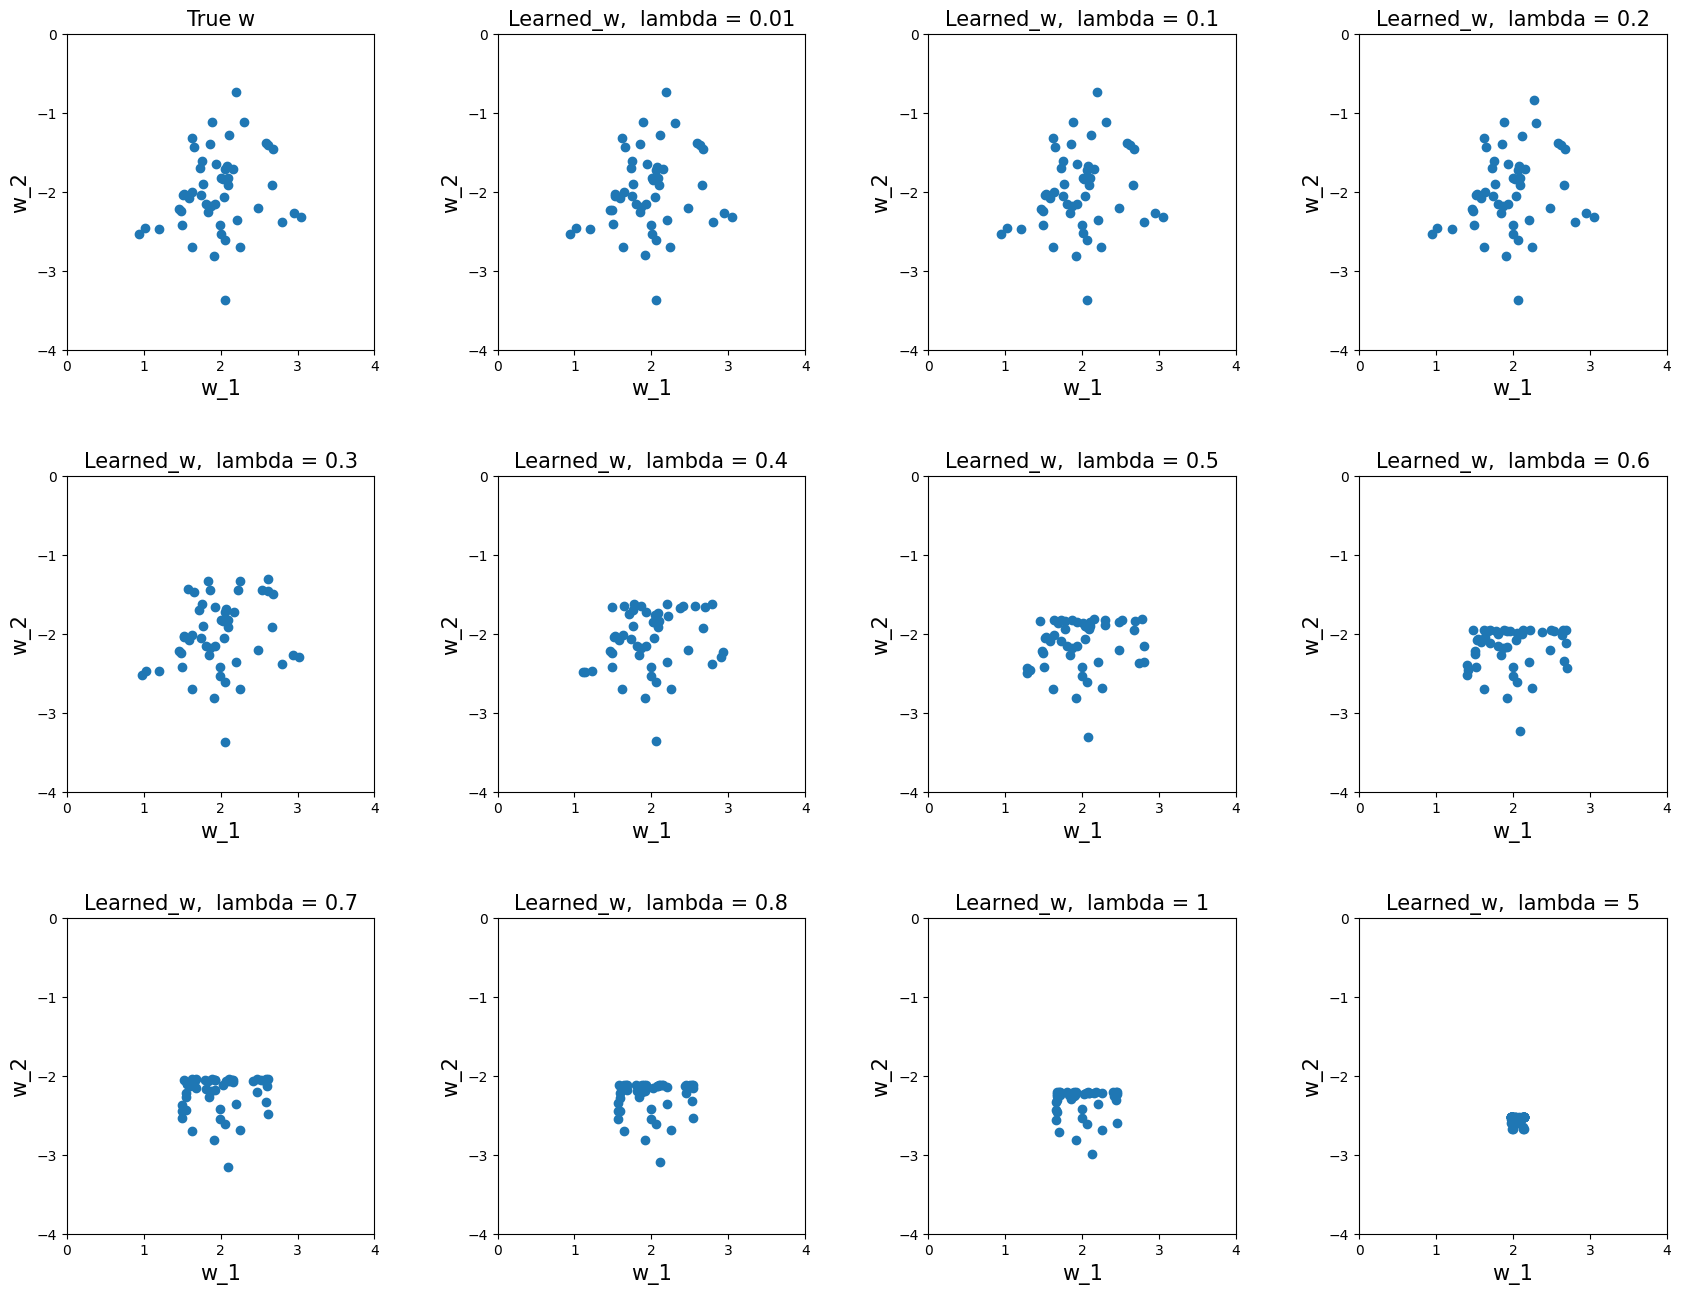

In [52]:
## 2norm squared, the resulted model weights will get closer to each other as lambda increase, however not identical. 
## this resembles the concept of smooth graph signals forced by 2norm squared.

epses = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,5] 
fig, axs = plt.subplots(3,4,figsize=(20,15))
cnt = 0
for i in range(3):
    for j in range(4):
        if cnt == 0:
            axs[i][j].scatter(results_7[2][0][2][:,0],results_7[2][0][2][:,1])

            axs[i][j].set_title('True w',fontsize=15)
        else:
            axs[i][j].scatter(results_7[2][cnt-1][1][:,0],results_7[2][cnt-1][1][:,1])
            axs[i][j].set_title('Learned_w,  lambda = {}'.format(epses[cnt-1]),fontsize=15)
        axs[i][j].set_yticks(np.arange(-4, 1, 1.0))
        axs[i][j].set_xticks(np.arange(0,5, 1.0))
        axs[i][j].set_xlabel('w_1',fontsize=15)
        axs[i][j].set_ylabel('w_2',fontsize=15)
        cnt+=1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)